<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>02. EDA para C_SEV</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---


## 2.0 Introducción

En este notebook nos serviremos del análisis realizado en el EDA para poder preparar los datos y utilizarlos para elaborar un modelo que nos permita clasificar según la posibilidad de fallecimientos dado un accidente.

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 2.0.1 Estructura

## Librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import nbconvert

%matplotlib inline

## Scripts

In [3]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import eda_tools

## 2.1 Carga de datos
Ahora realizamos la carga de los datos originales que analizamos en el EDA.

In [4]:
accidents_df = csv_tools.csv_import(origin = '../data/NCDB_1999_to_2014.csv')

Reading file...
Reading ended.


Ahora procederemos a modificarlos. Recordamos que el modelo propuesto busca tener información sobre un accidente y predecir la posible mortalidad del mismo. Para ello, como los datos se encuentran enfocados a definir la información de una persona en un accidente, y tenemos información para varias personas en el mismo accidente, debemos agregar los datos principalmente.

## 2.2 Preprocesado del dataset
Vamos a modificar el dataset original para que cumpla los requisitos necesario para ser utilizados en la elaboración de un modelo de clasificación de accidentes mortales o no. 

### 2.2.1 Eliminación de filas I

Lo primero que vamos a eliminar son las filas repetidas que observamos en el EDA general. Hacer esto primero nos permitirá eliminar filas y agilizar las tareas en el resto de código. 

In [5]:
accidents_df.drop_duplicates(keep='last', inplace=True)

Ahora procedemos a eliminar las filas con valores anómalos. En este caso hablamos de los vehículos del año 2015 que tuvieron un accidente en 2014. Estas filas carecen de sentido.

In [6]:
accidents_df = accidents_df.drop(accidents_df[accidents_df['V_YEAR'] == '2015'].index, axis=0)

Al analizar los datos pudimos observar como existian valores especiales. Para este modelo nos centramos en los valores ```N```, estos estaban presentes en las variables referentes a personas, las cuales eran valores *no aplicables* al no tratarse de personas involucradas en un accidente. En la agregación, no solo buscamos obtener una fila por accidente, sino que también crear una nueva variable como el total de personas involucradas en un accidente. Debemos eliminar los vehículos aparcados pues no son personas que puedan fallecer al verse en vueltas en un accidente.

In [7]:
per_columns = [['P_SEX', 'N'], ['P_AGE', 'NN'], ['P_PSN', 'NN'], 
               ['P_ISEV', 'N'], ['P_SAFE', 'NN'], ['P_USER', 'N']]

for col in per_columns:
    accidents_df = accidents_df.drop(accidents_df[accidents_df[col[0]] == col[1]].index, axis=0)

Verificamos que están fuera del dataset.

In [8]:
# Verifico que se han eliminado
per_columns = ['P_SEX', 'P_AGE', 'P_PSN', 
               'P_ISEV', 'P_SAFE', 'P_USER']
eda_tools.special_values_summary(df = accidents_df[per_columns], vals = [['N', 'NN']])

,column_name,N,N%,total,total%
0,P_SEX,0,[0.0],0,0.0
1,P_AGE,0,[0.0],0,0.0
2,P_PSN,0,[0.0],0,0.0
3,P_ISEV,0,[0.0],0,0.0
4,P_SAFE,0,[0.0],0,0.0
5,P_USER,0,[0.0],0,0.0


### 2.2.2 Agregación
Ahora ya podemos agregar las filas del dataset por accidente. Además realizaremos un conteo de filas de cada agregación, es decir, el número de personas involucradas en el accidente.

In [9]:
# Agregación final
acc_columns = ['C_YEAR', 'C_MNTH', 'C_WDAY', 
               'C_HOUR', 'C_SEV', 'C_VEHS', 
               'C_CONF', 'C_RCFG', 'C_WTHR', 
               'C_RSUR', 'C_RALN', 'C_TRAF']

sev_df = accidents_df.groupby(acc_columns).agg(C_PERS=('P_USER', 'count')).reset_index()
sev_df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS
0,1999,01,1,00,2,01,01,01,1,4,1,18,1
1,1999,01,1,00,2,01,01,01,1,5,1,18,1
2,1999,01,1,00,2,01,01,01,2,1,1,18,1
3,1999,01,1,00,2,01,01,01,6,3,2,18,2
4,1999,01,1,00,2,01,01,UU,1,2,3,18,1


### 2.2.3 Reducción de categorías

A raíz del EDA general, hemos podido observar ciertos aspectos de la distribucion de los datos en las categorías de las variables que nos permiten reducir sus valores, de forma que sea más sencillo manejarlas en el modelo. Es importante recordar que solo tratamos las categorías que no son valores especiales, pues esas serán tratadas en otra fase posterior. 

En concreto realizaremos las siguiente reducciones:

**Variable ```C_HOUR```**

Esta variable nos informa de la franja horaria donde ocurre el accidente. Esta posee un total de 23 categorías, debido a patrones comunes entre algunas de ellas tramificamos las franjas para agruparalas en 3 categorías.
1. Noche: de 20 a 6 horas
2. Mañana: de 7 a 13 horas
3. Tarde: de 14 a 19 horas

In [10]:
categories = {
    'night' : ['20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06'],
    'morning' : ['07', '08', '09', '10', '11', '12', '13'],
    'afternoon' : ['14', '15', '16', '17', '18', '19']
}

for cat in categories:
    sev_df['C_HOUR'] = sev_df['C_HOUR'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_HOUR')

,index,percentaje,C_HOUR
0,afternoon,39.242328,702845
1,morning,35.208857,630604
2,night,24.260903,434522
3,UU,1.287912,23067


**Variable ```C_CONF```**

Estas variable refleja la tipología del accidente, y es bastante dificil de reducir. Estas categorías poseen información tanto del número de vehículos implicados como del tipo de colisión. En nuestro caso vamos a reducirla para que solo muestre información del tipo de colisión:
1. object: [01, 02]
2. roll: [03, 04, 05]
3. back: [21]
4. side: [22, 32]
5. passby: [23, 24]
6. front: [31]
7. turn: [33, 34]
8. angle: [35]
3. other: [06, 25, 36, 41]

In [11]:
categories = {
    'object' : ['01', '02'],
    'roll' : ['03', '04', '05'],
    'back' : ['21'],
    'side' : ['22', '32'],
    'passby' : ['23', '24'],
    'front' : ['31'],
    'turn' : ['33', '34'],
    'angle' : ['35'],
    'other' : ['06', '25', '36', '41']
}

for cat in categories:
    sev_df['C_CONF'] = sev_df['C_CONF'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_CONF')

,index,percentaje,C_CONF
0,back,22.331464,399965
1,other,19.495734,349176
2,roll,12.631893,226242
3,angle,12.526256,224350
4,turn,7.743219,138684
5,object,6.153080,110204
6,QQ,5.912772,105900
7,side,4.021299,72023
8,UU,3.646489,65310
9,front,3.424439,61333


**Variable ```C_RCFG```**

Esta variable nos explica el tipo de carretera donde ocurrió el accidente. Nuestra propuesta es una reducción a dos categorías:
1. Normal: [01]
2. Especial: [el resto]

De esta forma diferenciamos la carretera normal del resto de carreteras de una tipología específica. La razón es que en su mayoría los datos que se tienen corresponden a carreteras normales, mientras que las de tipologñia específica son menos habituales.

In [12]:
categories = {
    'normal' : ['01'],
    'specific' : ['02', '03', '04', '05', '06', '07', '08', '09', '10']
}

for cat in categories:
    sev_df['C_RCFG'] = sev_df['C_RCFG'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_RCFG')

,index,percentaje,C_RCFG
0,specific,48.033989,860307
1,normal,38.702138,693170
2,UU,9.900962,177330
3,QQ,3.362910,60231


**Variable ```C_WTHR```**

Con esta variable sabemos la situación meteorológica durante el accidente. El análisis visual muestra como en situaciones de conducción normales o no severas (día soleado o lluvia moderada) los accidentes no tienen porque causar muertos, sin embargo, en situación climatológicas adversas es altamente probable:
1. normal [1, 3]
2. bad [2, 4, 5, 6, 7]

In [13]:
categories = {
    'normal' : ['1', '3'],
    'bad' : ['2', '4', '5', '6', '7']
}

for cat in categories:
    sev_df['C_WTHR'] = sev_df['C_WTHR'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_WTHR')

,index,percentaje,C_WTHR
0,normal,75.054521,1344255
1,bad,22.783604,408063
2,U,1.864450,33393
3,Q,0.297425,5327


**Variable ```C_RSUR```**

En esta variable analizamos las condiciones del asfalto. Al igual que en los casos anteriores la reducimos a dos categorias:
1. normal: [1, 2]
2. draged: [3, 4, 5, 6, 7, 8, 9]

In [14]:
categories = {
    'normal' : ['1', '2'],
    'dragged' : ['3', '4', '5', '6', '7', '8', '9']
}

for cat in categories:
    sev_df['C_RSUR'] = sev_df['C_RSUR'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_RSUR')

,index,percentaje,C_RSUR
0,normal,79.432597,1422668
1,dragged,15.399897,275818
2,Q,3.545318,63498
3,U,1.622188,29054


**Variable ```C_RALN```**

Aquí observamos el tipo de carretera. Visualmente se obaservaba como los accidentes mortales eran más probables en carreteras no rectas y con características de pendientes. Dividimos en dos categorías:
1. normal [1]
2. curve/ramp [el resto]

In [15]:
categories = {
    'normal' : ['1'],
    'curve/ramp' : ['2', '3', '4', '5', '6']
}

for cat in categories:
    sev_df['C_RALN'] = sev_df['C_RALN'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_RALN')

,index,percentaje,C_RALN
0,normal,64.104670,1148139
1,curve/ramp,27.126337,485843
2,U,8.170067,146329
3,Q,0.598926,10727


**Variable ```C_TRAF```**

Esta variable indica la presencia de medidas de seguridad. Como norma generla una carretera sin medidas de seguridad mostraba una elevada frecuencia de accidentes mortales.
1. safe [el resto]
2. unsafe [18]

In [16]:
categories = {
    'safe' : ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17'],
    'unsafe' : ['18']
}

for cat in categories:
    sev_df['C_TRAF'] = sev_df['C_TRAF'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_TRAF')

,index,percentaje,C_TRAF
0,unsafe,56.976792,1020476
1,safe,36.416536,652234
2,UU,4.905479,87859
3,QQ,1.701192,30469


**Variable ```C_MNTH```**
Esta variable vamos a realizar una reducción por estaciones del año, diviendo en dos categorías:
1. Otoño/Invierno [Octubre a Marzo]
2. Primavera/Verano [Abril a Septiembre]

In [17]:
categories = {
    'oto/inv' : ['10', '11', '12', '01', '02', '03'],
    'prim/ver' : ['04', '05', '06', '07', '08', '09']
}

for cat in categories:
    sev_df['C_MNTH'] = sev_df['C_MNTH'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_MNTH')

,index,percentaje,C_MNTH
0,oto/inv,52.649023,942964
1,prim/ver,47.345729,847980
2,UU,0.005248,94


**Variable ```C_WDAY```**
Esta variable vamos a realizar una reducción por entre semana y fin de semana (incluiremos viernes en la segunda al ser día de operaciones salida de manera muy frecuente):
1. week [01 a 04]
2. weekend [05 a 07]

In [26]:
categories = {
    'week' : ['1', '2', '3', '4'],
    'weekend' : ['5', '6', '7']
}

for cat in categories:
    sev_df['C_WDAY'] = sev_df['C_WDAY'].replace(to_replace = categories[cat], value = cat)

eda_tools.classes_overview(df = sev_df, obj_val = 'C_WDAY')

,index,percentaje,C_WDAY
0,week,57.245575,1025290
1,weekend,42.726955,765256
2,U,0.027470,492


### 2.2.4 Guardado del dataset final

In [27]:
sev_df.to_csv("../data/sev_df_02.csv", index = False)

## 2.3 Análisis
A continuación repetimos un pequeño análisis con le objetivo de valorar el resultado de las modificaciones y el dataset resultante.

### 2.3.1 Variable objetivo
Repasamos como ha quedado la variable objetivo después de la eliminación de filas:

In [28]:
eda_tools.classes_overview(df = sev_df, obj_val = 'C_SEV')

,index,percentaje,C_SEV
0,2,98.059561,1756284
1,1,1.940439,34754


Podemos ver como se sigue manteniendo el desequilibrio y de las mismas proporciones. Habrá que tenerlo en cuenta para el tratado posterior antes de efectuar la modelización.

### 2.3.2 Valores especiales
Repasamos la existencia de valores especiales que habrá que tratar en el preprocesado:

In [29]:
# Valores especiales
Q = ['Q', 'QQ', 'QQQQ']
U = ['U', 'UU', 'UUUU']
vals_hists = [Q, U]

eda_tools.special_values_summary(df=sev_df, vals=vals_hists)

,column_name,Q,Q%,U,U%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],94,[0.005],94,0.0
2,C_WDAY,0,[0.0],492,[0.027],492,0.0
3,C_HOUR,0,[0.0],23067,[1.288],23067,1.3
4,C_SEV,0,[0.0],0,[0.0],0,0.0
5,C_VEHS,0,[0.0],139,[0.008],139,0.0
6,C_CONF,105900,[5.913],65310,[3.646],171210,9.6
7,C_RCFG,60231,[3.363],177330,[9.901],237561,13.3
8,C_WTHR,5327,[0.297],33393,[1.864],38720,2.2
9,C_RSUR,63498,[3.545],29054,[1.622],92552,5.2


### 2.3.3 Variables numéricas
Realizamo un estudio de la nueva variable numérica creada: ```C_PERS```, que nos indica el número de personas involucradas en un accidente.

Vemos su correlación con la variable objetivo:

<AxesSubplot:>

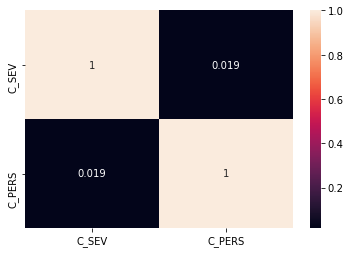

In [30]:
sns.heatmap(sev_df[['C_SEV', 'C_PERS']].corr(), annot=True)

Observamos como no tienen una correlación que pueda perjudicar al modelo. 

Ahora observamos sus principales características:

In [31]:
sev_df['C_PERS'].describe().apply(lambda x: '%.5f' % x)

count    1791038.00000
mean           2.93026
std            2.57987
min            1.00000
25%            1.00000
50%            2.00000
75%            4.00000
max          123.00000
Name: C_PERS, dtype: object

Observamos como los datos oscilan entre 1 a 4 personas involucradas en un accidente, siendo 3 personas aproximadamente la media de personas involucradas por accidente. Se observa un valor máximo muy elevado, que puede corresponder a un accidente múltiple. 

Analizamos visualmente en  busca de outliers:

<AxesSubplot:>

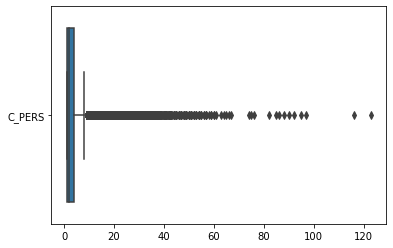

In [32]:
sns.boxplot(data=sev_df[['C_PERS']], orient="h")

Se observan varios accidentes que sobresalen de los valores medios, algunos de ellos bastante llamativos.

### 2.3.4 Variables categóricas
Realizamos un análisis de las variables categóricas del modelo. Destacamos el cambio realizado a las mismas anteriormente y procedemos a visualizar el resultado de esta reducción de categorías.

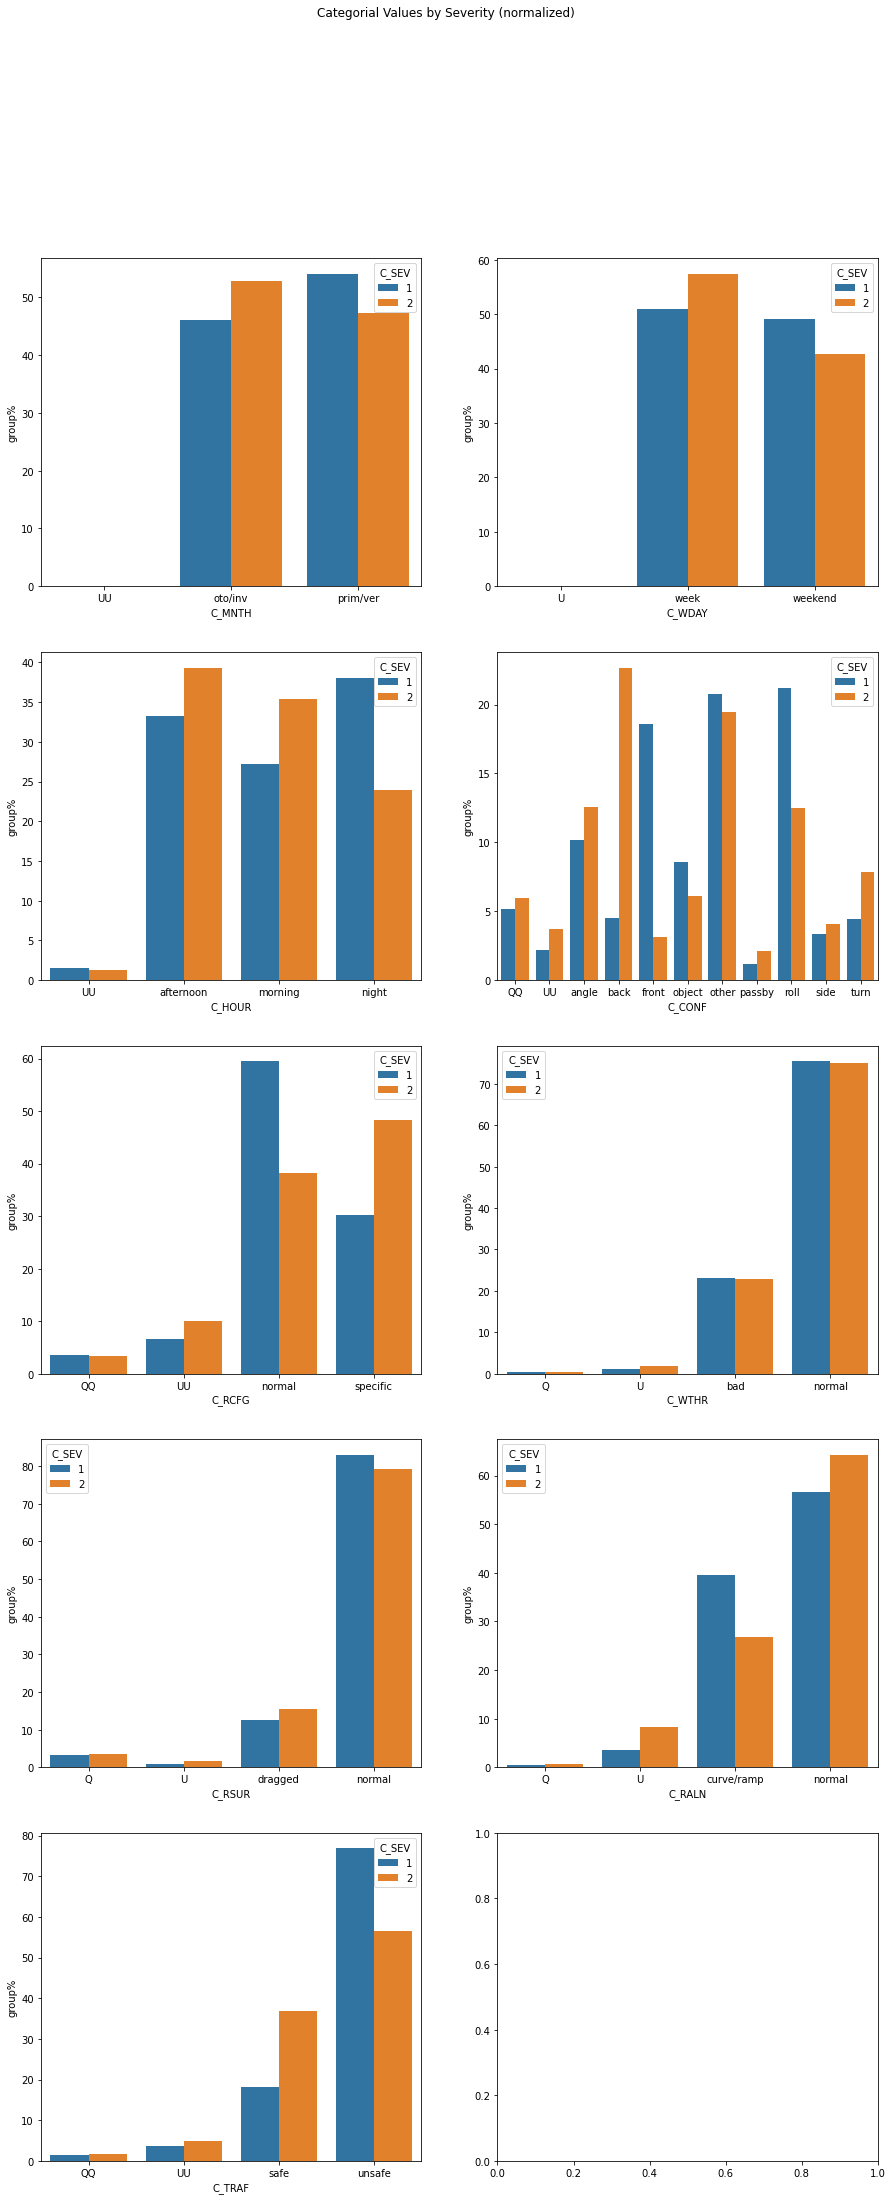

In [33]:
categorical = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF', 
               'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 
               'C_TRAF']

fig, axes = plt.subplots(5, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0
j = 0
for cat in categorical:
    temp = eda_tools.norm_category(df = sev_df, obj_val = 'C_SEV', cat_val = cat)
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'C_SEV', ax = axes[i,j]);
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

EXPLICAR UN POCO QUE SE VE Y PROPUESTAS DE ENCODING 

## 2.4 Conclusiones

SEGUIR EL FORMATO DE LAS CONCLUSIONES GENERALES DEL EDA
1. VARIABLE OBJETIVO (DESBALANCEO,...)
2. VARIABLE NUMÉRICA (RELACIÓN CON OTRAS VARIABLES, OUTILIERS, ...)
3. VARIABLE CATEGÓRICA (ENCODING, UTILIDAD, ...)

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 